In [1]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
# from libs.default_parameters import *
# from libs.simulation_tools import
from libs.satellite import *

from os import getcwd
from os.path import join, basename
from sys import path 

from tool import (
    append_bell_state, generate_star_bell_circuit, measure_star_users,
    sift_key_multi, apply_noise_model, compute_atm_loss, rytov_variance,
    Cn2_profile, compute_slant_distance, equivalent_beam_width_squared,
    rvs_LN_fading, rvs_pointing_err, _get_precalculated_channel_params,
    generate_insta_eta_optimized, binary_entropy, P, bbm92simulation,
    # Global parameters
    a, n_s, wavelength, h_OGS, h_s, h_atm, theta_rad, v_wind, mu_x, mu_y,
    sigma_theta_x, sigma_theta_y, e_0, p_dark, e_pol, lambda_val
)



In [2]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# bob用のリスト
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# alice用のリスト
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000
print(f'zenith_angle_alice_deg: {zenith_angle_alice_lst}')
print(f'zenith_angle_bob_deg: {zenith_angle_bob_lst}')


zenith_angle_alice_deg: [59.82220731 57.20571    54.31536344 51.11731306 47.5796426  43.67872882
 39.41103877 34.81442487 30.00638313 25.25323752 21.08758441 18.41782064
 18.22698246 20.60210441 24.62188856 29.33180312 34.15113304 38.78495184
 43.10028831 47.05110381 50.63677524 53.87901238 56.80904791 59.46070142
 61.86681358]
zenith_angle_bob_deg: [59.12231128 56.36761957 53.29942595 49.86960124 46.02580343 41.71462467
 36.88795594 31.51443373 25.59889386 19.2177631  12.61487602  6.7674352
  6.48171328 12.17404931 18.77234156 25.17778075 31.12682233 36.53619297
 41.39769812 45.74103304 49.61362622 53.06877427 56.15900865 58.93278366
 61.43314946]


In [3]:
tau_zen_lst = np.array([0.81, 0.75, 0.55])  # 各衛星パスの大気減衰係数
# tau_zen_lst = np.array([0.81])

qber_alice_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
yield_alice_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
qber_bob_values = np.zeros((len(tau_zen_lst), len(zenith_angle_bob_lst)))
yield_bob_values = np.zeros((len(tau_zen_lst), len(zenith_angle_bob_lst)))
qber_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
yield_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
skr_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
error_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [4]:
print(n_s)
def Q_lambda_func(eta_A, eta_B, lambda_val, p_dark):
    term1_denominator = (1 + eta_A * lambda_val)**2
    term2_denominator = (1 + eta_B * lambda_val)**2
    term3_denominator = (1 + eta_A * lambda_val + eta_B * lambda_val - eta_A * eta_B * lambda_val)**2

    min_denom = 1e-15

    q_lambda = 1.0 \
             - (1.0 - p_dark) / (term1_denominator + min_denom) \
             - (1.0 - p_dark) / (term2_denominator + min_denom) \
             + ((1.0 - p_dark) * (1.0 - p_dark)) / (term3_denominator + min_denom)
    
    return q_lambda

# --- NEW: Q_lambda の修正版 ---
def Q_lambda_func_modified(eta_A, eta_B, lambda_val, p_dark, e_0_val, e_pol_val):
    """
    Q(eta_A, eta_B, lambda, p_dark) の修正版。
    """
    # 既存の Q_lambda_func の結果を取得
    q_lambda_original = Q_lambda_func(eta_A, eta_B, lambda_val, p_dark)

    # 追加項の分母
    denom_term1 = (1 + eta_A * lambda_val)
    denom_term2 = (1 + eta_B * lambda_val)
    denom_term3 = (1 + eta_A * lambda_val + eta_B * lambda_val - eta_A * eta_B * lambda_val)
    
    min_denom = 1e-15 # ゼロ除算防止

    # 分母がゼロに近づかないようにクリッピング
    denom_product = (denom_term1 + min_denom) * (denom_term2 + min_denom) * (denom_term3 + min_denom)
    
    # 追加項
    additional_term = (2 * (e_0_val - e_pol_val) * eta_A * eta_B * lambda_val * (1 + lambda_val)) / (denom_product)

    # 修正された Q の値
    q_modified = e_0_val * q_lambda_original - additional_term
    
    return q_modified

def integrand_func(eta_B, eta_A, lambda_val_param, p_dark_param,
                   # Alice parameters for transmitivity_pdf
                   mu_x_A, mu_y_A, sigma_x_A, sigma_y_A, zenith_angle_rad_A,
                   w_L_A, w_Leq_A, tau_zen_A, varphi_mod_A, wavelength_A, h_OGS_A,
                   h_atm_A, Cn2_profile_A, a_A,
                   # Bob parameters for transmitivity_pdf
                   mu_x_B, mu_y_B, sigma_x_B, sigma_y_B, zenith_angle_rad_B,
                   w_L_B, w_Leq_B, tau_zen_B, varphi_mod_B, wavelength_B, h_OGS_B,
                   h_atm_B, Cn2_profile_B, a_B):
    
    Q_val = Q_lambda_func(eta_A, eta_B, lambda_val_param, p_dark_param)
    
    f_A = transmitivity_pdf(
        eta_A, mu_x_A, mu_y_A, sigma_x_A, sigma_y_A, zenith_angle_rad_A,
        w_L_A, w_Leq_A, tau_zen_A, varphi_mod_A, wavelength_A, h_OGS_A,
        h_atm_A, Cn2_profile_A, a_A
    )
    
    f_B = transmitivity_pdf(
        eta_B, mu_x_B, mu_y_B, sigma_x_B, sigma_y_B, zenith_angle_rad_B,
        w_L_B, w_Leq_B, tau_zen_B, varphi_mod_B, wavelength_B, h_OGS_B,
        h_atm_B, Cn2_profile_B, a_B
    )
    
    return Q_val * f_A * f_B

# --- NEW: 積分する関数 (修正版 Q_lambda * transmitivity_pdf_A * transmitivity_pdf_B) ---
def integrand_func_modified(eta_B, eta_A, lambda_val_param, p_dark_param, e_0_val_param, e_pol_val_param,
                   # Alice parameters for transmitivity_pdf
                   mu_x_A, mu_y_A, sigma_x_A, sigma_y_A, zenith_angle_rad_A,
                   w_L_A, w_Leq_A, tau_zen_A, varphi_mod_A, wavelength_A, h_OGS_A,
                   h_atm_A, Cn2_profile_A, a_A,
                   # Bob parameters for transmitivity_pdf
                   mu_x_B, mu_y_B, sigma_x_B, sigma_y_B, zenith_angle_rad_B,
                   w_L_B, w_Leq_B, tau_zen_B, varphi_mod_B, wavelength_B, h_OGS_B,
                   h_atm_B, Cn2_profile_B, a_B):
    
    Q_val_modified = Q_lambda_func_modified(eta_A, eta_B, lambda_val_param, p_dark_param, e_0_val_param, e_pol_val_param)
    
    f_A = transmitivity_pdf(
        eta_A, mu_x_A, mu_y_A, sigma_x_A, sigma_y_A, zenith_angle_rad_A,
        w_L_A, w_Leq_A, tau_zen_A, varphi_mod_A, wavelength_A, h_OGS_A,
        h_atm_A, Cn2_profile_A, a_A
    )
    
    f_B = transmitivity_pdf(
        eta_B, mu_x_B, mu_y_B, sigma_x_B, sigma_y_B, zenith_angle_rad_B,
        w_L_B, w_Leq_B, tau_zen_B, varphi_mod_B, wavelength_B, h_OGS_B,
        h_atm_B, Cn2_profile_B, a_B
    )
    
    return Q_val_modified * f_A * f_B

0.5


In [8]:
print(f"tau_zen_lst: {tau_zen_lst}")
for idx in range(len(tau_zen_lst)):
    print(f"tau_zen = {tau_zen_lst[idx]}")
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        print(f"zenith_angle_alice = {zenith_angle_alice_lst[jdx]}")
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        
        w_L_alice = slant_path_alice_lst[jdx] * theta_rad
        w_L_bob = slant_path_bob_lst[jdx] * theta_rad

        
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        alice_precalc_params = _get_precalculated_channel_params(zenith_angle_alice_deg, tau_zen_lst[idx])
        bob_precalc_params = _get_precalculated_channel_params(zenith_angle_bob_deg, tau_zen_lst[idx])
        zenith_angle_rad_alice = np.deg2rad(zenith_angle_alice_deg)
        sigma_R_alice = np.sqrt(alice_precalc_params['sigma_R_squared'])
        w_Leq_alice = np.sqrt(alice_precalc_params['w_Leq_squared'])
        w_L_alice = alice_precalc_params['w_L_beam']
        tau_zen_alice = tau_zen_lst[idx]
        slant_distance_alice = alice_precalc_params['slant_distance']
        sigma_x_alice = sigma_theta_x * slant_distance_alice
        sigma_y_alice = sigma_theta_y * slant_distance_alice

        zenith_angle_rad_bob = np.deg2rad(zenith_angle_bob_deg)
        sigma_R_bob = np.sqrt(bob_precalc_params['sigma_R_squared'])
        w_Leq_bob = np.sqrt(bob_precalc_params['w_Leq_squared'])
        w_L_bob = bob_precalc_params['w_L_beam']
        tau_zen_bob = tau_zen_lst[idx]
        slant_distance_bob = bob_precalc_params['slant_distance']
        sigma_x_bob = sigma_theta_x * slant_distance_bob
        sigma_y_bob = sigma_theta_y * slant_distance_bob
        sigma_mod_alice_val = compute_sigma_mod(mu_x, mu_y, sigma_x_alice, sigma_y_alice)
        varphi_mod_alice_val = sigma_to_variance(sigma_mod_alice_val, w_Leq_alice)
        
        sigma_mod_bob_val = compute_sigma_mod(mu_x, mu_y, sigma_x_bob, sigma_y_bob)
        varphi_mod_bob_val = sigma_to_variance(sigma_mod_bob_val, w_Leq_bob)
        lower_bound = 0
        upper_bound = 1
        
        integration_args_gain = (
            lambda_val, p_dark, # Use lambda_val (current_ns) here

            mu_x, mu_y, sigma_x_alice, sigma_y_alice, zenith_angle_rad_alice,
            w_L_alice, w_Leq_alice, tau_zen_alice, varphi_mod_alice_val, wavelength, h_OGS,
            h_atm, Cn2_profile, a,

            mu_x, mu_y, sigma_x_bob, sigma_y_bob, zenith_angle_rad_bob,
            w_L_bob, w_Leq_bob, tau_zen_bob, varphi_mod_bob_val, wavelength, h_OGS,
            h_atm, Cn2_profile, a
        )
        avg_overall_gain, integral_abserr_gain = dblquad(
            integrand_func,
            lower_bound, upper_bound,
            lambda eta_A: lower_bound,
            lambda eta_A: upper_bound,
            args=integration_args_gain
        )
        avg_overall_gain_scaled = avg_overall_gain / 2 # Convert to percentage

        # Theoretical Error
        integration_args_error = (
            lambda_val, p_dark, e_0, e_pol, # Use lambda_val (current_ns) and global e_0, e_pol

            mu_x, mu_y, sigma_x_alice, sigma_y_alice, zenith_angle_rad_alice,
            w_L_alice, w_Leq_alice, tau_zen_alice, varphi_mod_alice_val, wavelength, h_OGS,
            h_atm, Cn2_profile, a,

            mu_x, mu_y, sigma_x_bob, sigma_y_bob, zenith_angle_rad_bob,
            w_L_bob, w_Leq_bob, tau_zen_bob, varphi_mod_bob_val, wavelength, h_OGS,
            h_atm, Cn2_profile, a
        )
        avg_overall_error_modified, integral_abserr_error = dblquad(
                integrand_func_modified,
                lower_bound, upper_bound,
                lambda eta_A: lower_bound,
                lambda eta_A: upper_bound,
                args=integration_args_error
        )
        theoretical_qber = 0.0
        if avg_overall_gain > 1e-15: # Use raw gain, not scaled, for denominator
            theoretical_qber = avg_overall_error_modified / avg_overall_gain
        else:
            theoretical_qber = 0.5 # Default to 0.5 if theoretical gain is near zero
        qber_values[idx][jdx] = theoretical_qber
        print(f"  Overall QBER (Theoretical): {theoretical_qber:.8f}")
        print(f"  Overall Gain (Theoretical): {avg_overall_gain_scaled*100:.8f}")
        print("----------------------------------------")
        print(f"  Overall QBER (Theoretical): {theoretical_qber:.8f}")

tau_zen_lst: [0.81 0.75 0.55]
tau_zen = 0.81
zenith_angle_alice = 59.82220730839251
  Overall QBER (Theoretical): 0.14948690
  Overall Gain (Theoretical): 0.00153368
----------------------------------------
  Overall QBER (Theoretical): 0.14948690
zenith_angle_alice = 57.20571000088845
  Overall QBER (Theoretical): 0.14926852
  Overall Gain (Theoretical): 0.00218875
----------------------------------------
  Overall QBER (Theoretical): 0.14926852
zenith_angle_alice = 54.315363439554005
  Overall QBER (Theoretical): 0.14904452
  Overall Gain (Theoretical): 0.00310635
----------------------------------------
  Overall QBER (Theoretical): 0.14904452
zenith_angle_alice = 51.11731305941961
  Overall QBER (Theoretical): 0.14881221
  Overall Gain (Theoretical): 0.00437761
----------------------------------------
  Overall QBER (Theoretical): 0.14881221
zenith_angle_alice = 47.57964259638218
  Overall QBER (Theoretical): 0.14856728
  Overall Gain (Theoretical): 0.00611012
---------------------

/Users/yudai/miniconda3/envs/qkd_MS_env/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


  Overall QBER (Theoretical): 0.15088263
  Overall Gain (Theoretical): 0.00033742
----------------------------------------
  Overall QBER (Theoretical): 0.15088263
zenith_angle_alice = 57.20571000088845
  Overall QBER (Theoretical): 0.15049586
  Overall Gain (Theoretical): 0.00053780
----------------------------------------
  Overall QBER (Theoretical): 0.15049586
zenith_angle_alice = 54.315363439554005
  Overall QBER (Theoretical): 0.15016254
  Overall Gain (Theoretical): 0.00084543
----------------------------------------
  Overall QBER (Theoretical): 0.15016254
zenith_angle_alice = 51.11731305941961
  Overall QBER (Theoretical): 0.14986265
  Overall Gain (Theoretical): 0.00130915
----------------------------------------
  Overall QBER (Theoretical): 0.14986265
zenith_angle_alice = 47.57964259638218
  Overall QBER (Theoretical): 0.14958075
  Overall Gain (Theoretical): 0.00199176
----------------------------------------
  Overall QBER (Theoretical): 0.14958075
zenith_angle_alice = 43

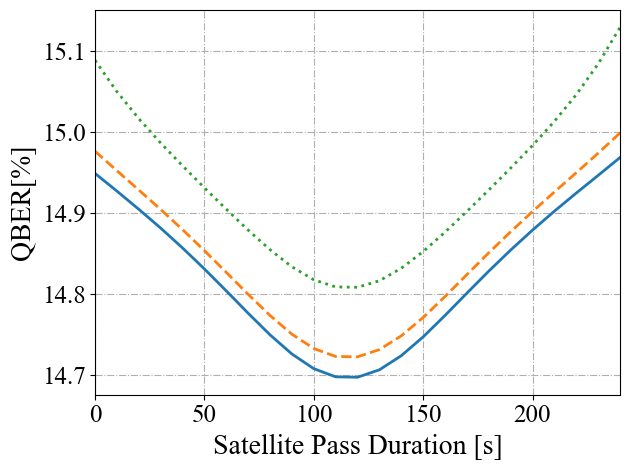

In [13]:
plt.plot(t, qber_values[0][:]*100)
plt.plot(t, qber_values[1][:]*100, ls='--')
plt.plot(t, qber_values[2][:]*100, ls=':')

plt.xlabel(r"Satellite Pass Duration [s]")
plt.ylabel(r"QBER[%]")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
plt.savefig('figure_results/analysis_qber_05.pdf')

In [10]:
np.save('results/qber_analysis_bbm92_test1_n_s05_new', qber_values)

In [14]:
np.save('results/qber_analysis_bbm92_test1_n_s1_new_081', qber_values)
# np.save('results/yield_analysis_bbm92_test1_n_s1_new', yield_values)

tau_zen = 0.81
tau_zen = 0.75
tau_zen = 0.55


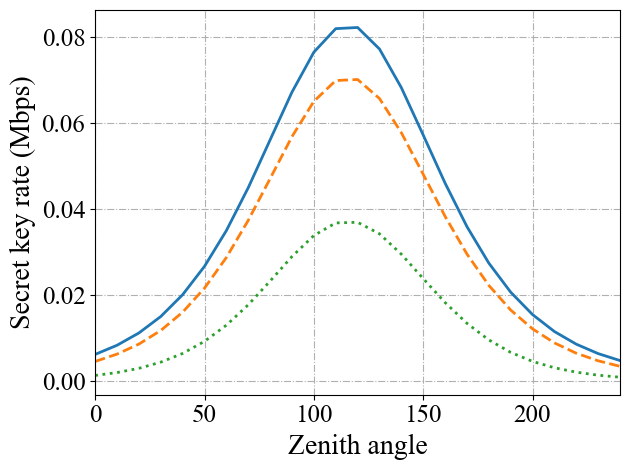

In [10]:
# Q_1, e_1 = compute_Q_1_e_1_ex(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )
# skr_values[idx][jdx] = compute_SKR(
#             qber_values[idx][jdx], yield_values[idx][jdx], Q_1, e_1
#         )
# Save QBER and yield arrays for further analysis
for idx in range(len(tau_zen_lst)):
    print(f"tau_zen = {tau_zen_lst[idx]}")
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        skr_values[idx][jdx] = compute_SKR_BBM92(
            qber_values[idx][jdx],
            yield_values[idx][jdx],
            rep_rate=1e9,
            sifting_coefficient=0.5,
            kr_efficiency=1.22
        )

plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')
plt.plot(t, skr_values[2][:]/10**6, ls=':')


# plt.plot(zenith_angle_deg_list, yield_values[0][:])
# plt.plot(zenith_angle_deg_list, yield_values[1][:], ls='--')

plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()
plt.savefig('figure_results/skr_plot.pdf')

# plt.savefig(f'results/skr_{n_s}.png')
# print(f"✅ Saved as: skr_{n_s}.png")

In [8]:
np.save('results/skr_analysis_bbm92_test1_n_s1_new', skr_values)